In [1]:
!pip install rectools > None

In [2]:
import requests
from copy import deepcopy
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from tqdm.auto import tqdm

from rectools import Columns
from rectools.dataset import Dataset, Interactions
from rectools.models.popular import PopularModel, Popularity
from rectools.models.popular_in_category import PopularInCategoryModel, RatioStrategy, MixingStrategy
from rectools.model_selection import TimeRangeSplitter
from rectools.metrics import MAP, Recall, calc_metrics

from scipy.stats import mode
import scipy.sparse as sps
from scipy.sparse import csr_matrix

from sklearn.linear_model import ElasticNet

from itertools import product

In [3]:
pd.set_option('max_colwidth', 400)

In [4]:
n_folds = 3
unit = "D"
n_units = 7
K_RECOS = 10
metrics = {
    "Recall@10": Recall(k=10),
    "MAP@10": MAP(k=10),
}

## Get data

In [5]:
url = "https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip"

req = requests.get(url, stream=True)

with open('kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

In [6]:
!unzip kion.zip

Archive:  kion.zip
   creating: kion_train/
  inflating: kion_train/interactions.csv  
  inflating: __MACOSX/kion_train/._interactions.csv  
  inflating: kion_train/users.csv    
  inflating: __MACOSX/kion_train/._users.csv  
  inflating: kion_train/items.csv    
  inflating: __MACOSX/kion_train/._items.csv  


In [7]:
interactions = pd.read_csv('kion_train/interactions.csv')
users = pd.read_csv('kion_train/users.csv')
items = pd.read_csv('kion_train/items.csv')

In [8]:
# rename columns, convert timestamp
interactions.rename(
    columns={
        'track_id': Columns.Item,
        'last_watch_dt': Columns.Datetime,
        'total_dur': Columns.Weight
    }, 
    inplace=True) 

interactions['datetime'] = pd.to_datetime(interactions['datetime'])

In [9]:
def headtail(df, n=5):
    return pd.concat([df.head(n), df.tail(n)])

## Competition submission preparation

In [12]:
submission = pd.read_csv('sample_submission.csv')
submission.head()

,user_id,item_id
0,3,"[9728, 15297, 10440, 14488, 13865, 12192, 341, 4151, 3734, 512]"
1,11,"[9728, 15297, 10440, 14488, 13865, 12192, 341, 4151, 3734, 512]"
2,29,"[9728, 15297, 10440, 14488, 13865, 12192, 341, 4151, 3734, 512]"
3,30,"[9728, 15297, 10440, 14488, 13865, 12192, 341, 4151, 3734, 512]"
4,33,"[9728, 15297, 10440, 14488, 13865, 12192, 341, 4151, 3734, 512]"


## Validation setup

In [13]:
interactions[Columns.Datetime].min(), interactions[Columns.Datetime].max()

(Timestamp('2021-03-13 00:00:00'), Timestamp('2021-08-22 00:00:00'))

In [14]:
daily_inters = interactions.groupby(Columns.Datetime)[Columns.User].agg('count')
daily_inters.name = 'interactions'
headtail(daily_inters)

datetime
2021-03-13    16104
2021-03-14    15606
2021-03-15    12363
2021-03-16    12643
2021-03-17    12753
2021-08-18    56789
2021-08-19    58640
2021-08-20    60145
2021-08-21    68834
2021-08-22    71171
Name: interactions, dtype: int64

In [15]:
#last_date = interactions[Columns.Datetime].max().normalize()
last_date = pd.to_datetime('15-08-2021', format='%d-%m-%Y')


start_date = last_date - pd.Timedelta(n_folds * n_units - 1, unit=unit)
periods = n_folds + 1
freq = f"{n_units}{unit}"
print(f"""
    start_date: {start_date}
    last_date: {last_date}
    periods: {periods}
    freq: {freq}
""")

date_range = pd.date_range(start=start_date, periods=periods, freq=freq, tz=last_date.tz)
date_range


    start_date: 2021-07-26 00:00:00
    last_date: 2021-08-15 00:00:00
    periods: 4
    freq: 7D



DatetimeIndex(['2021-07-26', '2021-08-02', '2021-08-09', '2021-08-16'], dtype='datetime64[ns]', freq='7D')

In [16]:
cv = TimeRangeSplitter(
    date_range=date_range,
    filter_already_seen=True,
    #filter_cold_items=True,
    #filter_cold_users=True,
)
cv

## Prepare data

### Binarize years in release_year feature

In [17]:
_, bins = pd.qcut(items["release_year"], 10, retbins=True)
labels = bins[:-1]

year_feature = pd.DataFrame(
    {
        Columns.Item: items[Columns.Item],
        "value": pd.cut(items["release_year"], bins=bins, labels=bins[:-1]),
        "feature": "release_year",
    }
)
year_feature.head()

,item_id,value,feature
0,10711,1983.0,release_year
1,2508,2012.0,release_year
2,10716,2009.0,release_year
3,7868,2014.0,release_year
4,16268,1897.0,release_year


### Split genres into list

In [18]:
items["genre"] = items["genres"].str.split(",")
items[["genre", "genres"]].head(3)

,genre,genres
0,"[драмы, зарубежные, детективы, мелодрамы]","драмы, зарубежные, детективы, мелодрамы"
1,"[зарубежные, приключения, комедии]","зарубежные, приключения, комедии"
2,"[криминал, зарубежные, триллеры, боевики, комедии]","криминал, зарубежные, триллеры, боевики, комедии"


In [19]:
genre_feature = items[[Columns.Item, "genre"]].explode("genre")
genre_feature.columns = [Columns.Item, "value"]
genre_feature["feature"] = "genre"
genre_feature.head()

,item_id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre


In [20]:
item_feat = pd.concat([genre_feature, year_feature])
item_feat = item_feat[item_feat[Columns.Item].isin(interactions[Columns.Item])]
item_feat.shape

(55676, 3)

### Construct dataset object to fit models

In [21]:
dataset = Dataset.construct(
    interactions_df=interactions,
    user_features_df=None,
    item_features_df=item_feat,
    cat_item_features=['genre', 'release_year']
)

## Tuning hyperparams utils

In [ ]:
def tune_hyperparams(cv, params, model_type, inters_obj, verbose=False, category_feature=None):
  params_grid = [item for item in product(*params.values())]
  fold_iterator = cv.split(inters_obj)
  results = []

  for i_fold, (train_ids, test_ids, _) in enumerate(fold_iterator):     
      df_train = inters_obj.df.iloc[train_ids]
      item_feat_train = item_feat[item_feat[Columns.Item].isin(df_train[Columns.Item])]
      
      dataset = Dataset.construct(
          interactions_df=df_train,
          user_features_df=None,
          item_features_df=item_feat_train,
          cat_item_features=['genre', 'release_year']
      )

      df_test = inters_obj.df.iloc[test_ids][Columns.UserItem]
      test_users = np.unique(df_test[Columns.User])

      for params_setup in params_grid:
        if category_feature:
          model = model_type(category_feature=category_feature)
        else:
          model = model_type()
        for i, param_name in enumerate(params.keys()): 
          setattr(model, param_name, params_setup[i])

        model.fit(dataset)
        recos = model.recommend(
              users=test_users,
              dataset=dataset,
              k=K_RECOS,
              filter_viewed=True,
        )
        metric_values = calc_metrics(
              metrics,
              reco=recos,
              interactions=df_test,
              prev_interactions=df_train
        )
        res = {"fold": i_fold, "model": f'{model_type.__name__} {str(params_setup)}'}
        res.update(metric_values)
        if verbose:
          print(res)
        results.append(res)
  return results

## Popular model

### Simple run

In [ ]:
%%time

popular_model = PopularModel()
popular_model.fit(dataset);

CPU times: user 3.36 s, sys: 13.8 ms, total: 3.37 s
Wall time: 3.36 s


In [ ]:
popular_model.recommend(
    dataset.user_id_map.external_ids[:1], 
    dataset=dataset, 
    k=10, 
    filter_viewed=False,  # True - throw away some items for each user
).merge(
    items[['item_id', 'title']], 
    on='item_id',
    how='left',
)

,user_id,item_id,score,rank,title
0,176549,10440,202457.0,1,Хрустальный
1,176549,15297,193123.0,2,Клиника счастья
2,176549,9728,132865.0,3,Гнев человеческий
3,176549,13865,122119.0,4,Девятаев
4,176549,4151,91167.0,5,Секреты семейной жизни
5,176549,3734,74803.0,6,Прабабушка легкого поведения
6,176549,2657,68581.0,7,Подслушано
7,176549,4880,55043.0,8,Афера
8,176549,142,45367.0,9,Маша
9,176549,6809,40372.0,10,Дуров


### Tune hyperparams

In [ ]:
params_grid = {
    'period': [
        pd.Timedelta(7, unit='d'),
        pd.Timedelta(1, unit='w'),
        pd.Timedelta(14, unit='d'),
        pd.Timedelta(28, unit='d'),
     ],
     'popularity': [Popularity.N_USERS, Popularity.N_INTERACTIONS, Popularity.MEAN_WEIGHT, Popularity.SUM_WEIGHT]
}

In [ ]:
cv = TimeRangeSplitter(
    date_range=date_range,
    filter_already_seen=True,
)

In [ ]:
inters = Interactions(interactions)

In [ ]:
%%time

val_results = tune_hyperparams(cv, params=params_grid, model_type=PopularModel, inters_obj=inters)

In [ ]:
val_results_df = pd.DataFrame(val_results)
val_results_df.head()

,fold,model,Recall@10,MAP@10
0,0,"PopularModel (Timedelta('7 days 00:00:00'), <Popularity.N_USERS: 'n_users'>)",0.218901,0.099084
1,0,"PopularModel (Timedelta('7 days 00:00:00'), <Popularity.N_INTERACTIONS: 'n_interactions'>)",0.218901,0.099084
2,0,"PopularModel (Timedelta('7 days 00:00:00'), <Popularity.MEAN_WEIGHT: 'mean_weight'>)",0.000026,0.000005
3,0,"PopularModel (Timedelta('7 days 00:00:00'), <Popularity.SUM_WEIGHT: 'sum_weight'>)",0.171421,0.078639
4,0,"PopularModel (Timedelta('7 days 00:00:00'), <Popularity.N_USERS: 'n_users'>)",0.218901,0.099084


In [ ]:
pivot_results = pd.DataFrame(val_results_df).drop(columns='fold').groupby(['model'], sort=False).agg(['mean', 'std']).sort_values(('MAP@10', 'mean'), ascending=False)
pivot_results.round(5)

Recall@10  \
                                                                                                 mean   
model                                                                                                   
PopularModel (Timedelta('7 days 00:00:00'), <Popularity.N_USERS: 'n_users'>)                  0.21546   
PopularModel (Timedelta('7 days 00:00:00'), <Popularity.N_INTERACTIONS: 'n_interactions'>)    0.21546   
PopularModel (Timedelta('14 days 00:00:00'), <Popularity.N_USERS: 'n_users'>)                 0.21065   
PopularModel (Timedelta('14 days 00:00:00'), <Popularity.N_INTERACTIONS: 'n_interactions'>)   0.21065   
PopularModel (Timedelta('28 days 00:00:00'), <Popularity.N_USERS: 'n_users'>)                 0.20293   
PopularModel (Timedelta('28 days 00:00:00'), <Popularity.N_INTERACTIONS: 'n_interactions'>)   0.20293   
PopularModel (Timedelta('28 days 00:00:00'), <Popularity.SUM_WEIGHT: 'sum_weight'>)           0.17833   
PopularModel (Timedelta('14 days 00:00:00'), <Popularity.SUM_WEIGHT: 'sum_weight'>)           0.16769   
PopularModel (Timedelta('7 days 00:00:00'), <Popularity.SUM_WEIGHT: 'sum_weight'>)            0.15918   
PopularModel (Timedelta('14 days 00:00:00'), <Popularity.MEAN_WEIGHT: 'mean_weight'>)         0.00016   
PopularModel (Timedelta('7 days 00:00:00'), <Popularity.MEAN_WEIGHT: 'mean_weight'>)          0.00028   
PopularModel (Timedelta('28 days 00:00:00'), <Popularity.MEAN_WEIGHT: 'mean_weight'>)         0.00015   

                                                                                                      \
                                                                                                 std   
model                                                                                                  
PopularModel (Timedelta('7 days 00:00:00'), <Popularity.N_USERS: 'n_users'>)                 0.00743   
PopularModel (Timedelta('7 days 00:00:00'), <Popularity.N_INTERACTIONS: 'n_interactions'>)   0.00743   
PopularModel (Timedelta('14 days 00:00:00'), <Popularity.N_USERS: 'n_users'>)                0.00488   
PopularModel (Timedelta('14 days 00:00:00'), <Popularity.N_INTERACTIONS: 'n_interactions'>)  0.00488   
PopularModel (Timedelta('28 days 00:00:00'), <Popularity.N_USERS: 'n_users'>)                0.01142   
PopularModel (Timedelta('28 days 00:00:00'), <Popularity.N_INTERACTIONS: 'n_interactions'>)  0.01142   
PopularModel (Timedelta('28 days 00:00:00'), <Popularity.SUM_WEIGHT: 'sum_weight'>)          0.01290   
PopularModel (Timedelta('14 days 00:00:00'), <Popularity.SUM_WEIGHT: 'sum_weight'>)          0.02227   
PopularModel (Timedelta('7 days 00:00:00'), <Popularity.SUM_WEIGHT: 'sum_weight'>)           0.01070   
PopularModel (Timedelta('14 days 00:00:00'), <Popularity.MEAN_WEIGHT: 'mean_weight'>)        0.00011   
PopularModel (Timedelta('7 days 00:00:00'), <Popularity.MEAN_WEIGHT: 'mean_weight'>)         0.00025   
PopularModel (Timedelta('28 days 00:00:00'), <Popularity.MEAN_WEIGHT: 'mean_weight'>)        0.00011   

                                                                                              MAP@10  \
                                                                                                mean   
model                                                                                                  
PopularModel (Timedelta('7 days 00:00:00'), <Popularity.N_USERS: 'n_users'>)                 0.09581   
PopularModel (Timedelta('7 days 00:00:00'), <Popularity.N_INTERACTIONS: 'n_interactions'>)   0.09581   
PopularModel (Timedelta('14 days 00:00:00'), <Popularity.N_USERS: 'n_users'>)                0.09578   
PopularModel (Timedelta('14 days 00:00:00'), <Popularity.N_INTERACTIONS: 'n_interactions'>)  0.09578   
PopularModel (Timedelta('28 days 00:00:00'), <Popularity.N_USERS: 'n_users'>)                0.09473   
PopularModel (Timedelta('28 days 00:00:00'), <Popularity.N_INTERACTIONS: 'n_interactions'>)  0.09473   
PopularModel (Timed

### Fit best popular model

In [ ]:
best_model = PopularModel(period=pd.Timedelta('7 days 00:00:00'), popularity=Popularity.N_USERS, add_cold=True)
best_model.fit(dataset);

In [ ]:
best_model.recommend(
    dataset.user_id_map.external_ids[:1], 
    dataset=dataset, 
    k=10, 
    filter_viewed=False,  # True - throw away some items for each user
).merge(
    items[['item_id', 'title']], 
    on='item_id',
    how='left',
)

,user_id,item_id,score,rank,title
0,176549,9728,15086.0,1,Гнев человеческий
1,176549,10440,14580.0,2,Хрустальный
2,176549,15297,14493.0,3,Клиника счастья
3,176549,13865,8244.0,4,Девятаев
4,176549,14488,8029.0,5,Мастер меча
5,176549,12192,7231.0,6,Фемида видит
6,176549,12360,7168.0,7,Круэлла
7,176549,341,6148.0,8,Лето - это море
8,176549,4151,6050.0,9,Секреты семейной жизни
9,176549,3734,5968.0,10,Прабабушка легкого поведения


In [ ]:
recs = pd.DataFrame({'user_id': submission['user_id'].unique()})
cold = recs[~recs['user_id'].isin(dataset.user_id_map.external_ids)]
warm = recs[recs['user_id'].isin(dataset.user_id_map.external_ids)]
cold.head()

,user_id
2,29
4,33
11,70
12,74
14,85


In [ ]:
warm_recs = best_model.recommend(warm['user_id'], dataset=dataset, k=10, filter_viewed=False).drop(['score', 'rank'], axis=1)
warm_recs = warm_recs.groupby('user_id').agg({'item_id': list}).reset_index()
warm_recs.head()

,user_id,item_id
0,3,"[9728, 10440, 15297, 13865, 14488, 12192, 12360, 341, 4151, 3734]"
1,11,"[9728, 10440, 15297, 13865, 14488, 12192, 12360, 341, 4151, 3734]"
2,30,"[9728, 10440, 15297, 13865, 14488, 12192, 12360, 341, 4151, 3734]"
3,39,"[9728, 10440, 15297, 13865, 14488, 12192, 12360, 341, 4151, 3734]"
4,46,"[9728, 10440, 15297, 13865, 14488, 12192, 12360, 341, 4151, 3734]"


In [ ]:
cold['item_id'] = [warm_recs['item_id'].values[0]]*len(cold)
cold.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,user_id,item_id
2,29,"[9728, 10440, 15297, 13865, 14488, 12192, 12360, 341, 4151, 3734]"
4,33,"[9728, 10440, 15297, 13865, 14488, 12192, 12360, 341, 4151, 3734]"
11,70,"[9728, 10440, 15297, 13865, 14488, 12192, 12360, 341, 4151, 3734]"
12,74,"[9728, 10440, 15297, 13865, 14488, 12192, 12360, 341, 4151, 3734]"
14,85,"[9728, 10440, 15297, 13865, 14488, 12192, 12360, 341, 4151, 3734]"


In [ ]:
recs = pd.concat((warm_recs, cold))
assert recs.shape == submission.shape

In [ ]:
recs.to_csv('popular_best_recs.csv', index=False)

### Sandbox leaderboard result

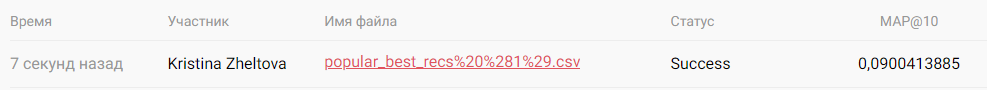

## Popular in category - with genre feature

### Simple run

In [ ]:
%%time

pop_cat = PopularInCategoryModel(category_feature='genre', n_categories=5)
pop_cat.fit(dataset);

CPU times: user 18.7 s, sys: 733 ms, total: 19.4 s
Wall time: 19.4 s


In [ ]:
pop_cat.recommend(
    dataset.user_id_map.external_ids[:1], 
    dataset=dataset, 
    k=10, 
    filter_viewed=False,
).merge(
    items[['item_id', 'title']], 
    on='item_id',
    how='left',
)

,user_id,item_id,score,rank,title
0,176549,15297,193123.0,1,Клиника счастья
1,176549,9728,132865.0,2,Гнев человеческий
2,176549,12192,38242.0,3,Фемида видит
3,176549,7829,20017.0,4,Поступь хаоса
4,176549,849,13713.0,5,Дебошир
5,176549,13865,122119.0,6,Девятаев
6,176549,7571,28372.0,7,100% волк
7,176549,2657,68581.0,8,Подслушано
8,176549,1844,24375.0,9,Аферистка
9,176549,142,45367.0,10,Маша


### Tune hyperparams

In [ ]:
params_grid = {
    'period': [
        pd.Timedelta(7, unit='d'),
        pd.Timedelta(14, unit='d'),
        pd.Timedelta(28, unit='d'),
     ],
     '': [Popularity.N_USERS, Popularity.N_INTERACTIONS],
     'ratio_strategy': [RatioStrategy.PROPORTIONAL, RatioStrategy.EQUAL],
     'n_categories': [5]
}

In [ ]:
cv = TimeRangeSplitter(
    date_range=date_range,
    filter_already_seen=True,
)

In [ ]:
inters = Interactions(interactions)

In [ ]:
%%time

val_results = tune_hyperparams(cv, params=params_grid, model_type=PopularInCategoryModel, inters_obj=inters, category_feature='genre', verbose=1)

In [ ]:
val_results_df = pd.DataFrame(val_results)
val_results_df.head()

,fold,model,Recall@10,MAP@10
0,0,"PopularInCategoryModel (Timedelta('7 days 00:00:00'), <Popularity.N_USERS: 'n_users'>, <RatioStrategy.PROPORTIONAL: 'proportional'>, 5)",0.158247,0.074175
1,0,"PopularInCategoryModel (Timedelta('7 days 00:00:00'), <Popularity.N_USERS: 'n_users'>, <RatioStrategy.EQUAL: 'equal'>, 5)",0.158248,0.074275
2,0,"PopularInCategoryModel (Timedelta('7 days 00:00:00'), <Popularity.N_INTERACTIONS: 'n_interactions'>, <RatioStrategy.PROPORTIONAL: 'proportional'>, 5)",0.157613,0.072832
3,0,"PopularInCategoryModel (Timedelta('7 days 00:00:00'), <Popularity.N_INTERACTIONS: 'n_interactions'>, <RatioStrategy.EQUAL: 'equal'>, 5)",0.158252,0.072749
4,0,"PopularInCategoryModel (Timedelta('14 days 00:00:00'), <Popularity.N_USERS: 'n_users'>, <RatioStrategy.PROPORTIONAL: 'proportional'>, 5)",0.162655,0.076862


In [ ]:
pivot_results = pd.DataFrame(val_results_df).drop(columns='fold').groupby(['model'], sort=False).agg(['mean', 'std']).sort_values(('MAP@10', 'mean'), ascending=False)
pivot_results.round(5)

Recall@10  \
                                                                                                                                                            mean   
model                                                                                                                                                              
PopularInCategoryModel (Timedelta('14 days 00:00:00'), <Popularity.N_USERS: 'n_users'>, <RatioStrategy.EQUAL: 'equal'>, 5)                               0.16021   
PopularInCategoryModel (Timedelta('7 days 00:00:00'), <Popularity.N_USERS: 'n_users'>, <RatioStrategy.EQUAL: 'equal'>, 5)                                0.16424   
PopularInCategoryModel (Timedelta('14 days 00:00:00'), <Popularity.N_USERS: 'n_users'>, <RatioStrategy.PROPORTIONAL: 'proportional'>, 5)                 0.16147   
PopularInCategoryModel (Timedelta('7 days 00:00:00'), <Popularity.N_USERS: 'n_users'>, <RatioStrategy.PROPORTIONAL: 'proportional'>, 5)                  0.16423   
PopularInCategoryModel (Timedelta('28 days 00:00:00'), <Popularity.N_USERS: 'n_users'>, <RatioStrategy.EQUAL: 'equal'>, 5)                               0.14962   
PopularInCategoryModel (Timedelta('7 days 00:00:00'), <Popularity.N_INTERACTIONS: 'n_interactions'>, <RatioStrategy.EQUAL: 'equal'>, 5)                  0.16394   
PopularInCategoryModel (Timedelta('28 days 00:00:00'), <Popularity.N_INTERACTIONS: 'n_interactions'>, <RatioStrategy.EQUAL: 'equal'>, 5)                 0.15066   
PopularInCategoryModel (Timedelta('14 days 00:00:00'), <Popularity.N_INTERACTIONS: 'n_interactions'>, <RatioStrategy.EQUAL: 'equal'>, 5)                 0.15749   
PopularInCategoryModel (Timedelta('28 days 00:00:00'), <Popularity.N_USERS: 'n_users'>, <RatioStrategy.PROPORTIONAL: 'proportional'>, 5)                 0.15038   
PopularInCategoryModel (Timedelta('7 days 00:00:00'), <Popularity.N_INTERACTIONS: 'n_interactions'>, <RatioStrategy.PROPORTIONAL: 'proportional'>, 5)    0.16370   
PopularInCategoryModel (Timedelta('14 days 00:00:00'), <Popularity.N_INTERACTIONS: 'n_interactions'>, <RatioStrategy.PROPORTIONAL: 'proportional'>, 5)   0.15784   
PopularInCategoryModel (Timedelta('28 days 00:00:00'), <Popularity.N_INTERACTIONS: 'n_interactions'>, <RatioStrategy.PROPORTIONAL: 'proportional'>, 5)   0.15070   

                                                                                                                                                                 \
                                                                                                                                                            std   
model                                                                                                                                                             
PopularInCategoryModel (Timedelta('14 days 00:00:00'), <Popularity.N_USERS: 'n_users'>, <RatioStrategy.EQUAL: 'equal'>, 5)                              0.00360   
PopularInCategoryModel (Timedelta('7 days 00:00:00'), <Popularity.N_USERS: 'n_users'>, <RatioStrategy.EQUAL: 'equal'>, 5)                               0.01010   
PopularInCategoryModel (Timedelta('14 days 00:00:00'), <Popularity.N_USERS: 'n_users'>, <RatioStrategy.PROPORTIONAL: 'proportional'>, 5)                0.00355   
PopularInCategoryModel (Timedelta('7 days 00:00:00'), <Popularity.N_USERS: 'n_users'>, <RatioStrategy.PROPORTIONAL: 'proportional'>, 5)                 0.01013   
PopularInCategoryModel (Timedelta('28 days 00:00:00'), <Popularity.N_USERS: 'n_users'>, <RatioStrategy.EQUAL: 'equal'>, 5)                              0.00553   
PopularInCategoryModel (Timedelta('7 days 00:00:00'), <Popularity.N_INTERACTIONS: 'n_interactions'>, <RatioStrategy.EQUAL: 'equal'>, 5)                 0.01033   
PopularInCategoryModel (Timedelta('28 days 00:00:00'), <Popularity.N_INTERACTIONS: 'n_interactions'>, <RatioStrategy.EQUAL: 'equal'>, 5)                0.00300   
PopularInCategoryModel (Timedelta('14 days 00:00:00'), <Popu

All metrics got worse

### Fit best popular in category model

In [ ]:
best_model = PopularInCategoryModel(category_feature='genre', period=pd.Timedelta(14, unit='d'), popularity=Popularity.N_USERS, ratio_strategy=RatioStrategy.EQUAL, n_categories=5)
best_model.fit(dataset);

In [ ]:
best_model.recommend(
    dataset.user_id_map.external_ids[:1], 
    dataset=dataset, 
    k=10, 
    filter_viewed=False,
).merge(
    items[['item_id', 'title']], 
    on='item_id',
    how='left',
)

,user_id,item_id,score,rank,title
0,176549,15297,26746.0,1,Клиника счастья
1,176549,12192,12671.0,2,Фемида видит
2,176549,9728,27061.0,3,Гнев человеческий
3,176549,14488,8031.0,4,Мастер меча
4,176549,11863,7059.0,5,Девятаев - сериал
5,176549,13865,14089.0,6,Девятаев
6,176549,12360,9938.0,7,Круэлла
7,176549,7793,10151.0,8,Радиовспышка
8,176549,7571,4555.0,9,100% волк
9,176549,3784,3588.0,10,Маленький воин


In [ ]:
recs = pd.DataFrame({'user_id': submission['user_id'].unique()})
cold = recs[~recs['user_id'].isin(dataset.user_id_map.external_ids)]
warm = recs[recs['user_id'].isin(dataset.user_id_map.external_ids)]
cold.head()

,user_id
2,29
4,33
11,70
12,74
14,85


In [ ]:
warm_recs = best_model.recommend(warm['user_id'], dataset=dataset, k=10, filter_viewed=False).drop(['score', 'rank'], axis=1)
warm_recs = warm_recs.groupby('user_id').agg({'item_id': list}).reset_index()
warm_recs.head()

,user_id,item_id
0,3,"[15297, 12192, 9728, 14488, 11863, 13865, 12360, 7793, 7571, 3784]"
1,11,"[15297, 12192, 9728, 14488, 11863, 13865, 12360, 7793, 7571, 3784]"
2,30,"[15297, 12192, 9728, 14488, 11863, 13865, 12360, 7793, 7571, 3784]"
3,39,"[15297, 12192, 9728, 14488, 11863, 13865, 12360, 7793, 7571, 3784]"
4,46,"[15297, 12192, 9728, 14488, 11863, 13865, 12360, 7793, 7571, 3784]"


In [ ]:
cold['item_id'] = [warm_recs['item_id'].values[0]]*len(cold)
recs = pd.concat((warm_recs, cold))
assert recs.shape == submission.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
recs.to_csv('popular_best_in_category.csv', index=False)

### Sandbox leaderboard result

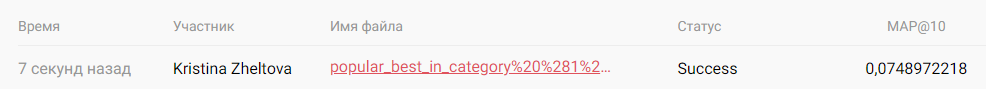

## Popular covered by n% of unique users

### Custom model class

In [56]:
class PopularNCovered:
  def __init__(self):
    self.item_set = None
    self.covered_users = None

  def fit(self, dataset, n_users=1000):
    assert dataset.format == 'csr'
    self.item_set, self.covered_users = self.__get_top_items_covered_users(
        dataset,
         n_users
    )

  def get_popular_items(self, dataset):
    return dataset.item_id_map.convert_to_external(self.item_set) 

  def recommend(self, user_ids, k=10):
    k_popular = self.get_popular_items(dataset)[:k].tolist()
    recos = [k_popular for i in range(len(user_ids))]
    res = pd.DataFrame(list(zip(user_ids.tolist(), recos)), columns=['user_id', 'item_id'])
    return res

  def __get_top_items_covered_users(self, matrix, n_users):
    item_set = []
    covered_users = np.zeros(matrix.shape[0], dtype=bool)
    while covered_users.sum() < n_users: 
        top_item = mode(matrix[~covered_users].indices)[0][0] 
        item_set.append(top_item)
        covered_users += np.maximum.reduceat(matrix.indices==top_item, matrix.indptr[:-1], dtype=bool) 
    return item_set, covered_users

In [22]:
# get csr matrix from interactions
matrix = dataset.get_user_item_matrix()

In [57]:
popular_n_covered = PopularNCovered()

In [37]:
popular_n_covered = PopularNCovered()
for n_users in range(1, matrix.shape[0], 100000):
    popular_n_covered.fit(matrix, n_users=n_users)
    print(f'items {popular_n_covered.item_set} cover {popular_n_covered.covered_users.sum()} unique users')

items [25] cover 202457 unique users
items [25] cover 202457 unique users
items [25] cover 202457 unique users
items [25, 21] cover 331646 unique users
items [25, 21, 32] cover 408629 unique users
items [25, 21, 32, 16, 93, 174] cover 509873 unique users
items [25, 21, 32, 16, 93, 174, 84, 122, 112, 142, 10, 68, 173, 357] cover 606335 unique users
items [25, 21, 32, 16, 93, 174, 84, 122, 112, 142, 10, 68, 173, 357, 233, 370, 131, 18, 11, 42, 148, 338, 216, 259, 157, 527, 445, 690, 515, 60, 282, 103, 202, 36, 2, 363, 15, 92] cover 700394 unique users
items [25, 21, 32, 16, 93, 174, 84, 122, 112, 142, 10, 68, 173, 357, 233, 370, 131, 18, 11, 42, 148, 338, 216, 259, 157, 527, 445, 690, 515, 60, 282, 103, 202, 36, 2, 363, 15, 92, 51, 203, 235, 598, 146, 457, 86, 1046, 1657, 72, 587, 337, 80, 44, 200, 1532, 127, 261, 297, 516, 97, 521, 509, 227, 382, 1187, 246, 38, 171, 412, 1504, 736, 420, 596, 965, 28, 1321, 332, 215, 69, 624, 502, 1087, 57, 26, 1316, 415, 7, 237, 1007, 501, 1088, 12, 467

In [54]:
popular_n_covered.fit(matrix, n_users=600000)
pop_covered = popular_n_covered.get_popular_items(dataset)
pop_covered

array([10440, 15297,  9728, 13865,  2657,  4151,  3734,  6809,  4740,
        4880,  7571, 11237,  8636, 14741])

In [ ]:
top_10_recs = pd.DataFrame(pop_covered, columns=['item_id']).merge(items[['item_id', 'title']], on='item_id', how='left').head(10)
top_10_recs

,item_id,title
0,10440,Хрустальный
1,15297,Клиника счастья
2,9728,Гнев человеческий
3,13865,Девятаев
4,2657,Подслушано
5,4151,Секреты семейной жизни
6,3734,Прабабушка легкого поведения
7,6809,Дуров
8,4740,Сахаров. Две жизни
9,4880,Афера


In [60]:
popular_n_covered.fit(matrix, n_users=600000)
res = popular_n_covered.recommend(submission['user_id'].values, k=10)
res.head()

,user_id,item_id
0,3,"[10440, 15297, 9728, 13865, 2657, 4151, 3734, 6809, 4740, 4880]"
1,11,"[10440, 15297, 9728, 13865, 2657, 4151, 3734, 6809, 4740, 4880]"
2,29,"[10440, 15297, 9728, 13865, 2657, 4151, 3734, 6809, 4740, 4880]"
3,30,"[10440, 15297, 9728, 13865, 2657, 4151, 3734, 6809, 4740, 4880]"
4,33,"[10440, 15297, 9728, 13865, 2657, 4151, 3734, 6809, 4740, 4880]"


In [ ]:
recs.to_csv('popular_covered_by_n_600000.csv', index=False)

### Sandbox leaderboard result

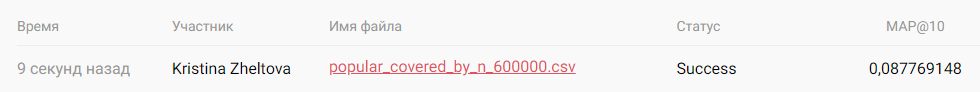

## SLIM

In [61]:
class SLIM:
    def __init__(self, l1_ratio):
        self.l1_ratio = l1_ratio 
        self.dataset = None
        self.model = None

    def _get_user_ratings(self, user_id):
        return self.dataset[user_id]

    def fit(self, X):
        self.dataset = X
        n_items = X.shape[1]
        self.model = ElasticNet(
            l1_ratio=self.l1_ratio,
            fit_intercept=False,
            copy_X=False
        )

        values, rows, cols = [], [], []

        # fit each item's factors sequentially
        for j in tqdm(range(n_items)):
            y = X[:, j].toarray()
            start = X.indptr[j]
            end = X.indptr[j + 1]
            backup = X.data[start:end].copy()
            X.data[start:end] = 0.0
            self.model.fit(X, y)

            non_zero_ids = self.model.coef_ > 0.0
            values.extend(self.model.coef_[non_zero_ids])
            rows.extend(np.arange(n_items)[non_zero_ids])
            cols.extend(np.ones(non_zero_ids.sum()) * j)

            X.data[start:end] = backup

        self.W = sps.csc_matrix((values, (rows, cols)), shape=(n_items, n_items), dtype=np.float32)

    def recommend(self, user_id, n=None):
        user_profile = self._get_user_ratings(user_id)
        scores = user_profile.dot(self.W).toarray().ravel()
        ranking = scores.argsort()[::-1]
        return ranking[:n]

In [62]:
def create_interaction_matrix(df, user_column='user_id', item_column='item_id'):
    users = CategoricalDtype(sorted(df[user_column].unique()), ordered=True)
    items = CategoricalDtype(sorted(df[item_column].unique()), ordered=True)
    df['score'] = 1 
    row = df[user_column].astype(users).cat.codes
    col = df[item_column].astype(items).cat.codes
    sparse_matrix = csr_matrix((df['score'], (row, col)), \
                               shape=(users.categories.size, items.categories.size))
    return sparse_matrix

interaction_matrix = create_interaction_matrix(interactions)

In [63]:
assert interaction_matrix.shape == (interactions['user_id'].nunique(), interactions['item_id'].nunique())

In [79]:
user_mapping = pd.DataFrame()
user_mapping['user_id'] = interactions['user_id']
user_mapping['new_index'] = user_mapping['user_id'].astype(CategoricalDtype(sorted(interactions['user_id'].unique()), ordered=True)).cat.codes

In [80]:
user_mapping.head()

,user_id,new_index
0,176549,154689
1,699317,612887
2,656683,575496
3,864613,758103
4,964868,846007


In [64]:
%%time

slim_model = SLIM(l1_ratio=0.6)
slim_model.fit(interaction_matrix)

  0%|          | 0/15706 [00:00<?, ?it/s]

CPU times: user 1h 20min 25s, sys: 38min 18s, total: 1h 58min 43s
Wall time: 1h 17min 39s


In [81]:
slim_model.recommend(user_id=154689, n=10)

array([15705,  5244,  5242,  5241,  5240,  5239,  5238,  5237,  5236,
        5235])

In [95]:
recs = pd.DataFrame({'user_id': submission['user_id'].unique()})
cold = recs[~recs['user_id'].isin(user_mapping['user_id'])]
warm = recs[recs['user_id'].isin(user_mapping['user_id'])]

Recos for warm users

In [96]:
warm_recs = {}
for user_id in tqdm(warm['user_id'].values):
  warm_recs[user_id] = slim_model.recommend(user_id=user_mapping[user_mapping['user_id'] == user_id]['new_index'].values[0], n=10).tolist()

  0%|          | 0/128170 [00:00<?, ?it/s]

In [100]:
warm_recs = pd.DataFrame(list(zip(warm_recs.keys(), warm_recs.values())), columns=['user_id', 'item_id'])

Popular for cold users

In [117]:
cold_recs = [[9728, 10440, 15297, 13865, 14488, 12192, 12360, 341, 4151, 3734] for i in range(len(cold['user_id']))]
cold_recs = pd.DataFrame(list(zip(cold['user_id'].values.tolist(), cold_recs)), columns=['user_id', 'item_id'])

Combine all

In [118]:
res = pd.concat((cold_recs, warm_recs))
assert res.shape[0] == submission.shape[0]
res.to_csv('slim.csv', index=False)   

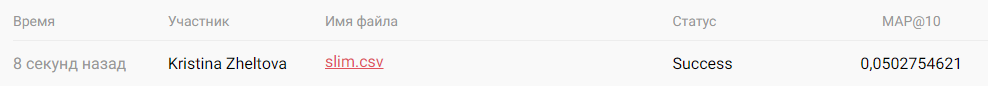